In [ ]:
from google.colab import drive

import numpy as np

import pandas as pd

from scipy.stats import (
  chi2_contingency,
  pointbiserialr,
  randint,
  uniform,
  ttest_ind,
)
from scipy.stats.contingency import association

import seaborn as sns

import shap

from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
  classification_report,
  PrecisionRecallDisplay,
  RocCurveDisplay,
)
from sklearn.model_selection import (
  cross_val_score,
  train_test_split,
  RandomizedSearchCV,
)
from sklearn.preprocessing import (
  LabelEncoder,
  MinMaxScaler,
  OneHotEncoder,
  OrdinalEncoder,
)

import xgboost as xgb

from tabulate import tabulate

import matplotlib.pyplot as plt

In [ ]:
HEX_BLUE = '#48a8c4'
HEX_RED = '#c0504d'

In [ ]:
df = pd.read_csv('/content/bank_churn_data - bank_churn_data.csv')
df.head()

,user_id,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,...,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


1. EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   10127 non-null  int64  
 1   attrition_flag            10127 non-null  object 
 2   customer_age              10127 non-null  int64  
 3   gender                    10127 non-null  object 
 4   dependent_count           10127 non-null  int64  
 5   education_level           10127 non-null  object 
 6   marital_status            10127 non-null  object 
 7   income_category           10127 non-null  object 
 8   card_category             10127 non-null  object 
 9   months_on_book            10127 non-null  int64  
 10  total_relationship_count  10127 non-null  int64  
 11  months_inactive_12_mon    10127 non-null  int64  
 12  contacts_count_12_mon     10127 non-null  int64  
 13  credit_limit              10127 non-null  float64
 14  total_

In [ ]:
df.isna().sum()

,0
user_id,0
attrition_flag,0
customer_age,0
gender,0
dependent_count,0
education_level,0
marital_status,0
income_category,0
card_category,0
months_on_book,0


In [ ]:
object_cols = [
    'attrition_flag',
    'gender',
    'education_level',
    'marital_status',
    'income_category',
    'card_category'
]

In [ ]:
for col in object_cols:
    df[col] = df[col].astype('category')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   user_id                   10127 non-null  int64   
 1   attrition_flag            10127 non-null  category
 2   customer_age              10127 non-null  int64   
 3   gender                    10127 non-null  category
 4   dependent_count           10127 non-null  int64   
 5   education_level           10127 non-null  category
 6   marital_status            10127 non-null  category
 7   income_category           10127 non-null  category
 8   card_category             10127 non-null  category
 9   months_on_book            10127 non-null  int64   
 10  total_relationship_count  10127 non-null  int64   
 11  months_inactive_12_mon    10127 non-null  int64   
 12  contacts_count_12_mon     10127 non-null  int64   
 13  credit_limit              10127 non-null  floa

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,10127.0,7.391776e+08,3.690378e+07,708082083.0,7.130368e+08,7.179264e+08,7.731435e+08,8.283431e+08
customer_age,10127.0,4.632596e+01,8.016814e+00,26.0,4.100000e+01,4.600000e+01,5.200000e+01,7.300000e+01
dependent_count,10127.0,2.346203e+00,1.298908e+00,0.0,1.000000e+00,2.000000e+00,3.000000e+00,5.000000e+00
months_on_book,10127.0,3.592841e+01,7.986416e+00,13.0,3.100000e+01,3.600000e+01,4.000000e+01,5.600000e+01
total_relationship_count,10127.0,3.812580e+00,1.554408e+00,1.0,3.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00
months_inactive_12_mon,10127.0,2.341167e+00,1.010622e+00,0.0,2.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00
contacts_count_12_mon,10127.0,2.455317e+00,1.106225e+00,0.0,2.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00
credit_limit,10127.0,8.631954e+03,9.088777e+03,1438.3,2.555000e+03,4.549000e+03,1.106750e+04,3.451600e+04
total_revolving_bal,10127.0,1.162814e+03,8.149873e+02,0.0,3.590000e+02,1.276000e+03,1.784000e+03,2.517000e+03
avg_open_to_buy,10127.0,7.469140e+03,9.090685e+03,3.0,1.324500e+03,3.474000e+03,9.859000e+03,3.451600e+04


In [ ]:
df['customer_age'].describe()

,customer_age
count,10127.000000
mean,46.325960
std,8.016814
min,26.000000
25%,41.000000
50%,46.000000
75%,52.000000
max,73.000000


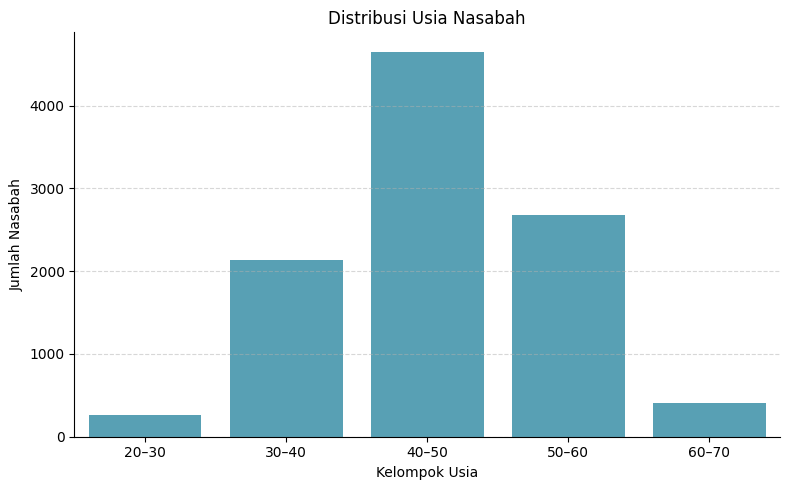

In [ ]:
# Kelompokkan usia ke dalam rentang
age_bins = pd.cut(df['customer_age'], bins=[20, 30, 40, 50, 60, 70])
age_group_counts = age_bins.value_counts().sort_index()
age_labels = [f"{interval.left:.0f}–{interval.right:.0f}" for interval in age_group_counts.index]

# Visualisasi jumlah nasabah per kelompok usia
plt.figure(figsize=(8, 5))
sns.barplot(x=age_labels, y=age_group_counts.values, color=HEX_BLUE)
sns.despine()
plt.title('Distribusi Usia Nasabah')
plt.xlabel('Kelompok Usia')
plt.ylabel('Jumlah Nasabah')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Menampilkan jumlah nasabah (20 - 30 tahun, 30 - 40 tahun, dst)

Mayoritas nasabah berada di rentang 40 - 50 tahun

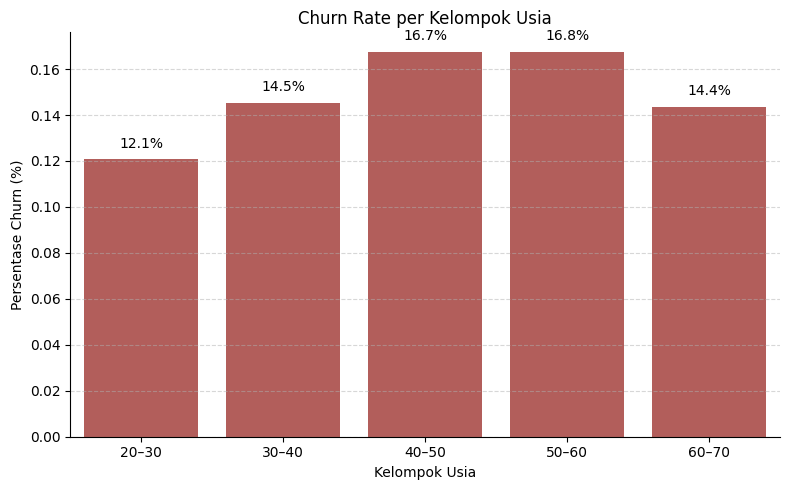

In [ ]:
# Hitung churn rate per kelompok usia
churn_rate_by_age = (
    df.groupby(age_bins, observed=True)['attrition_flag']
    .value_counts(normalize=True)
    .unstack()['Attrited Customer']
)

# Visualisasi churn rate
plt.figure(figsize=(8, 5))
sns.barplot(x=age_labels, y=churn_rate_by_age.values, color=HEX_RED)

# Tambahkan label persentase di atas bar
for i, rate in enumerate(churn_rate_by_age.values):
    plt.text(i, rate + 0.005, f"{rate:.1%}", ha='center', fontsize=10)

sns.despine()
plt.title('Churn Rate per Kelompok Usia')
plt.xlabel('Kelompok Usia')
plt.ylabel('Persentase Churn (%)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Kelompok usia 50 - 60 tahun memiliki churn rate tertinggi yaitu 16.8%, menunjukkan bahwa pelanggan di rentang usia ini lebih berisiko untuk churn dibanding kelompok lainnya

In [ ]:
# Tentukan urutan kategori income dan pendidikan
income_order = ['Unknown', 'Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +']
education_order = ['Unknown', 'Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate']

# Ubah jadi kategori terurut
df['income_category'] = pd.Categorical(df['income_category'], categories=income_order, ordered=True)
df['education_level'] = pd.Categorical(df['education_level'], categories=education_order, ordered=True)

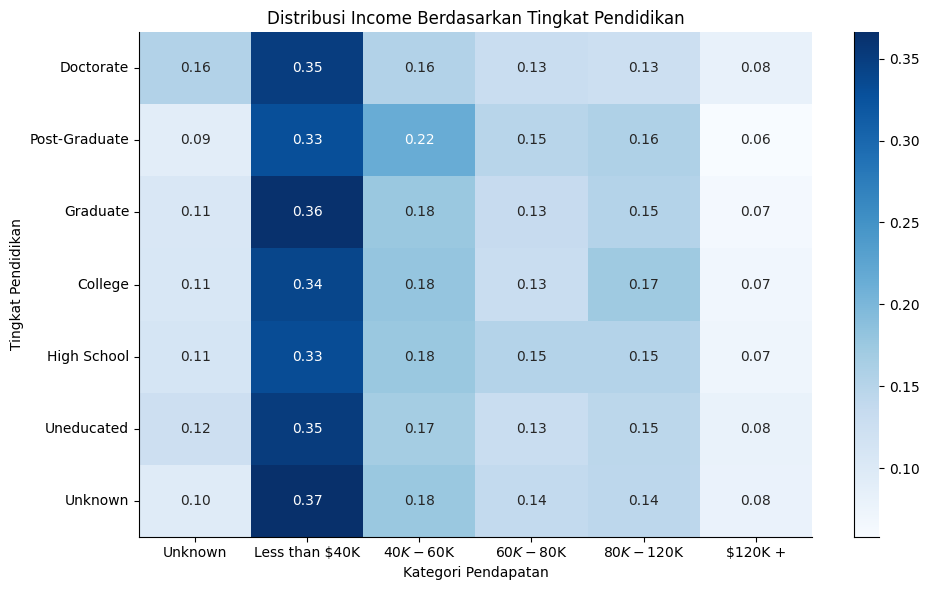

In [ ]:
# Crosstab antara pendidikan dan pendapatan
# Menggunakan dropna=False untuk memastikan semua kategori muncul, meskipun hitungannya 0
edu_income_ct = pd.crosstab(df['education_level'], df['income_category'], normalize='index', dropna=False)

# Secara eksplisit menyusun ulang baris DataFrame menggunakan urutan yang diinginkan (dari bawah ke atas)
edu_income_ct = edu_income_ct.reindex(index=education_order, columns=income_order, fill_value=0)

# Membalik urutan baris DataFrame untuk mendapatkan urutan visual dari atas ke bawah di heatmap
edu_income_ct = edu_income_ct.iloc[::-1]


plt.figure(figsize=(10, 6))
# Menggunakan ordered categories secara otomatis akan mengurutkan heatmap
sns.heatmap(edu_income_ct, annot=True, cmap='Blues', fmt='.2f')
sns.despine()
plt.title('Distribusi Income Berdasarkan Tingkat Pendidikan')
plt.xlabel('Kategori Pendapatan')
plt.ylabel('Tingkat Pendidikan')
plt.tight_layout()
plt.show()

Terdapat korelasi antara tingkat pendidikan dan kategori pendapatan. Namun tidak sepenuhnya linier

Meskipun secara umum pendidikan tinggi diasosiasikan dengan pendapatan lebih tinggi, data menunjukkan bahwa nasabah dengan gelar Doctorate tetap banyak yang berada di kategori Less than $40K

Karena dataset tidak mencakup informasi tentang bidang pekerjaan, posisi jabatan, atau pengalaman kerja, kita tidak bisa memastikan penyebab pastinya

Hal ini menunjukkan bahwa jenjang pendidikan tidak selalu berbanding lurus dengan kategori income, setidaknya dalam konteks data ini

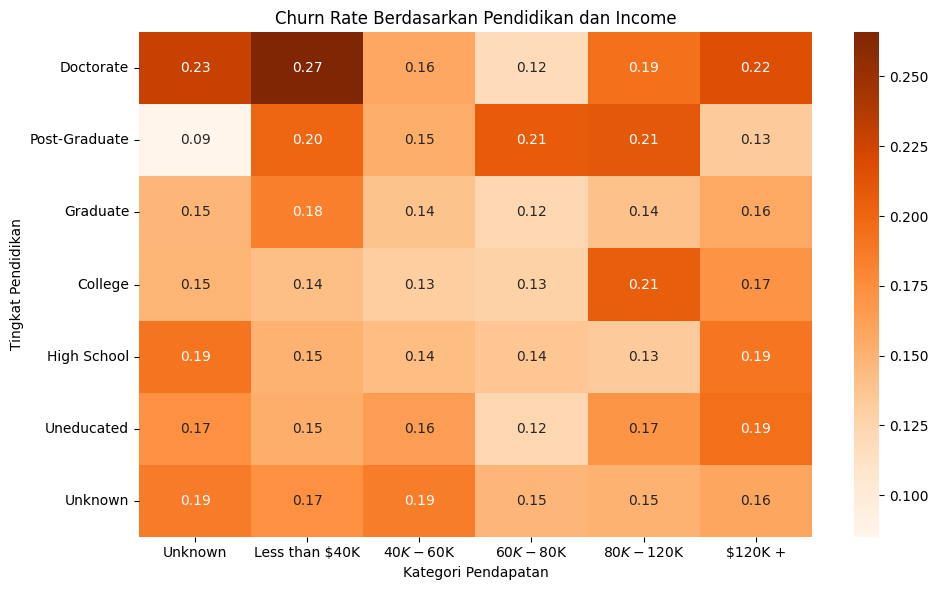

In [ ]:
# Hitung churn rate per kombinasi pendidikan dan income
# Menggunakan dropna=False untuk memastikan semua kategori muncul, meskipun hitungannya 0
churn_rate_combo = pd.crosstab(
    df['education_level'],
    df['income_category'],
    values=df['attrition_flag'].map({'Attrited Customer': 1, 'Existing Customer': 0}).astype(float),
    aggfunc='mean',
    dropna=False
)

# Secara eksplisit menyusun ulang baris dan kolom DataFrame menggunakan urutan yang diinginkan
churn_rate_combo = churn_rate_combo.reindex(index=education_order, columns=income_order, fill_value=0)

# Membalik urutan baris DataFrame untuk mendapatkan urutan visual dari atas ke bawah di heatmap
churn_rate_combo = churn_rate_combo.iloc[::-1]

plt.figure(figsize=(10, 6))
sns.heatmap(churn_rate_combo, annot=True, cmap='Oranges', fmt='.2f')
plt.title('Churn Rate Berdasarkan Pendidikan dan Income')
plt.xlabel('Kategori Pendapatan')
plt.ylabel('Tingkat Pendidikan')
plt.tight_layout()
plt.show()

Tidak diprediksi secara konsisten oleh tingkat pendidikan atau kategori pendapatan secara terpisah. Sebaliknya, churn dipengaruhi oleh kombinasi spesifik keduanya. Nasabah bergelar Doctorate memiliki churn rate tinggi baik di kategori income rendah (< $40K) maupun tinggi ($120K+), dengan selisih yang relatif kecil. Ini menunjukkan bahwa hubungan antara kedua variabel dan churn bersifat kompleks dan tidak linier.”

In [ ]:
# Hitung manual untuk wanita (F)
female_customers = df[df['gender'] == 'F']
female_churn_counts = female_customers['attrition_flag'].value_counts()

total_female = female_churn_counts.sum()
female_churned = female_churn_counts.get('Attrited Customer', 0) # Use .get to handle case where count is 0

female_churn_rate = female_churned / total_female if total_female > 0 else 0

print(f"--- Nasabah Wanita (F) ---")
print(f"Jumlah Nasabah Churn: {female_churned}")
print(f"Total Nasabah: {total_female}")
print(f"Churn Rate: {female_churn_rate:.4f} ({female_churn_rate*100:.1f}%)")

# Hitung manual untuk pria (M)
male_customers = df[df['gender'] == 'M']
male_churn_counts = male_customers['attrition_flag'].value_counts()

total_male = male_churn_counts.sum()
male_churned = male_churn_counts.get('Attrited Customer', 0) # Use .get to handle case where count is 0

male_churn_rate = male_churned / total_male if total_male > 0 else 0

print(f"\n--- Nasabah Pria (M) ---")
print(f"Jumlah Nasabah Churn: {male_churned}")
print(f"Total Nasabah: {total_male}")
print(f"Churn Rate: {male_churn_rate:.4f} ({male_churn_rate*100:.1f}%)")

--- Nasabah Wanita (F) ---
Jumlah Nasabah Churn: 930
Total Nasabah: 5358
Churn Rate: 0.1736 (17.4%)

--- Nasabah Pria (M) ---
Jumlah Nasabah Churn: 697
Total Nasabah: 4769
Churn Rate: 0.1462 (14.6%)


In [ ]:
# Hitung churn rate berdasarkan gender
churn_by_gender = (
    df.groupby('gender', observed=True)['attrition_flag']
    .value_counts(normalize=True)
    .unstack()
)
churn_by_gender['Churn Rate'] = churn_by_gender['Attrited Customer']

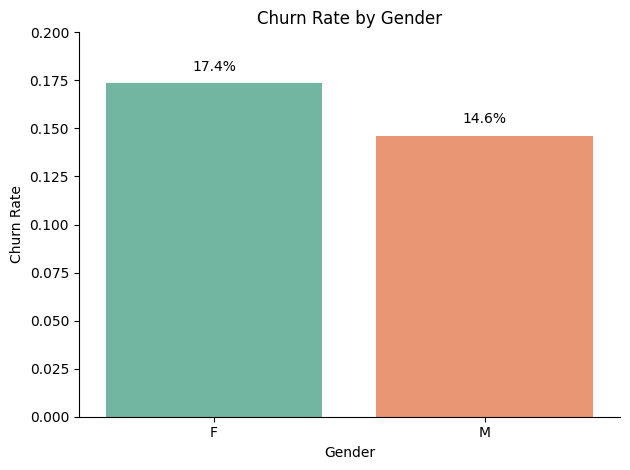

In [ ]:
# Barplot churn rate per gender (tanpa hue)
ax = sns.barplot(
    x='gender',
    y='Churn Rate',
    data=churn_by_gender.reset_index(),
    hue='gender',           # tambahkan hue agar palette tidak error
    palette='Set2',
    legend=False            # agar tidak muncul legenda ganda
)

# Buat label persentase otomatis dari data
churn_labels = churn_by_gender['Churn Rate'].apply(lambda x: f'{x*100:.1f}%').tolist()

# Tambahkan label persentase di atas bar
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.005,
        churn_labels[i % len(churn_labels)],  # handle duplikasi bar dari hue
        ha='center',
        va='bottom',
        fontsize=10
    )

# Styling
sns.despine()
plt.title('Churn Rate by Gender')
plt.ylabel('Churn Rate')
plt.xlabel('Gender')
plt.ylim(0, 0.20)
plt.tight_layout()
plt.show()

Selisih churn rate antara wanita (17.4%) dan pria (14.6%) terlihat cukup besar terutama karena churn rate masing-masing gender tidak tinggi secara absolut (di bawah 20%). Dalam konteks ini, selisih ~2.8% mencerminkan perbedaan relatif yang signifikan, bukan sekadar fluktuasi kecil

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   user_id                   10127 non-null  int64   
 1   attrition_flag            10127 non-null  category
 2   customer_age              10127 non-null  int64   
 3   gender                    10127 non-null  category
 4   dependent_count           10127 non-null  int64   
 5   education_level           10127 non-null  category
 6   marital_status            10127 non-null  category
 7   income_category           10127 non-null  category
 8   card_category             10127 non-null  category
 9   months_on_book            10127 non-null  int64   
 10  total_relationship_count  10127 non-null  int64   
 11  months_inactive_12_mon    10127 non-null  int64   
 12  contacts_count_12_mon     10127 non-null  int64   
 13  credit_limit              10127 non-null  floa

In [ ]:
df['churn'] = df['attrition_flag'].map({
    'Attrited Customer': 1,
    'Existing Customer': 0
})

In [ ]:
df.drop(columns=['user_id', 'attrition_flag'], inplace=True)

In [ ]:
df_clean = df.copy()

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   customer_age              10127 non-null  int64   
 1   gender                    10127 non-null  category
 2   dependent_count           10127 non-null  int64   
 3   education_level           10127 non-null  category
 4   marital_status            10127 non-null  category
 5   income_category           10127 non-null  category
 6   card_category             10127 non-null  category
 7   months_on_book            10127 non-null  int64   
 8   total_relationship_count  10127 non-null  int64   
 9   months_inactive_12_mon    10127 non-null  int64   
 10  contacts_count_12_mon     10127 non-null  int64   
 11  credit_limit              10127 non-null  float64 
 12  total_revolving_bal       10127 non-null  int64   
 13  avg_open_to_buy           10127 non-null  floa

In [ ]:
X = df_clean.drop(columns='churn')
y = df_clean['churn'].astype(int)  # pastikan target numerik
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
df_encoded = pd.get_dummies(df_clean, drop_first=True)
df_encoded.head()

,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,...,marital_status_Unknown,income_category_Less than $40K,income_category_$40K - $60K,income_category_$60K - $80K,income_category_$80K - $120K,income_category_$120K +,card_category_Gold,card_category_Platinum,card_category_Silver,churn_0
0,45,3,39,5,1,3,12691.0,777,11914.0,1.335,...,False,False,False,True,False,False,False,False,False,True
1,49,5,44,6,1,2,8256.0,864,7392.0,1.541,...,False,True,False,False,False,False,False,False,False,True
2,51,3,36,4,1,0,3418.0,0,3418.0,2.594,...,False,False,False,False,True,False,False,False,False,True
3,40,4,34,3,4,1,3313.0,2517,796.0,1.405,...,True,True,False,False,False,False,False,False,False,True
4,40,3,21,5,1,0,4716.0,0,4716.0,2.175,...,False,False,False,True,False,False,False,False,False,True


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Fitur kategorikal
cat_features = ['gender', 'education_level', 'marital_status', 'income_category', 'card_category']

# ColumnTransformer untuk encoding
encoder = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), cat_features)
    ],
    remainder='passthrough'  # biar fitur numerik tetap masuk
)

# Transformasi
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

In [ ]:
# Ambil nama kolom hasil encoding
encoded_cols = encoder.named_transformers_['cat'].get_feature_names_out(cat_features)

# Gabungkan dengan kolom numerik
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
final_cols = list(encoded_cols) + num_cols

# Buat DataFrame hasil encoding
X_train_df = pd.DataFrame(X_train_encoded, columns=final_cols)
X_train_df.head()

,gender_M,education_level_Doctorate,education_level_Graduate,education_level_High School,education_level_Post-Graduate,education_level_Uneducated,education_level_Unknown,marital_status_Married,marital_status_Single,marital_status_Unknown,...,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,3.0,2.0,2570.0,2230.0,340.0,0.686,1755.0,42.0,0.448,0.868
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.0,3.0,25276.0,0.0,25276.0,0.849,2282.0,38.0,0.583,0.000
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,3.0,1.0,11670.0,915.0,10755.0,0.892,4277.0,89.0,0.854,0.078
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,3.0,3124.0,1593.0,1531.0,0.869,1652.0,41.0,0.367,0.510
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.0,3.0,34516.0,1185.0,33331.0,0.725,3874.0,72.0,0.714,0.034


2. Model Machine Learning

Preprocessing untuk Modeling

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Tentukan fitur numerik dan kategorikal
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['category']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop='first'), cat_features)
])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [ ]:
# Ambil nama kolom numerik setelah scaling
num_cols_scaled = [f'num__{col}' for col in num_features]

# Ambil nama kolom kategorikal setelah encoding
cat_cols_encoded = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)

# Gabungkan semuanya
final_feature_names = list(num_cols_scaled) + list(cat_cols_encoded)

# Buat DataFrame hasil preprocessing
X_train_df = pd.DataFrame(X_train_processed, columns=final_feature_names)
X_train_df.head()

,num__customer_age,num__dependent_count,num__months_on_book,num__total_relationship_count,num__months_inactive_12_mon,num__contacts_count_12_mon,num__credit_limit,num__total_revolving_bal,num__avg_open_to_buy,num__total_amt_chng_q4_q1,...,marital_status_Single,marital_status_Unknown,income_category_$40K - $60K,income_category_$60K - $80K,income_category_$80K - $120K,income_category_Less than $40K,income_category_Unknown,card_category_Gold,card_category_Platinum,card_category_Silver
0,-1.301232,-1.809900,-1.513205,0.122196,0.646495,-0.411236,-0.665434,1.303942,-0.783057,-0.335597,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.299340,0.501503,-0.000700,0.765411,-0.342413,0.489635,1.848571,-1.433246,1.977862,0.407489,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.048867,-0.268965,-0.756952,1.408625,0.646495,-1.312106,0.342117,-0.310139,0.370094,0.603518,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-1.301232,-0.268965,-1.513205,-0.521019,-1.331320,0.489635,-0.604095,0.522064,-0.651190,0.498665,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.452079,-1.039432,0.503468,0.122196,-0.342413,0.489635,2.871622,0.021269,2.869713,-0.157803,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Tampilkan semua nama kolom
X_train_df.columns.tolist()

['num__customer_age',
 'num__dependent_count',
 'num__months_on_book',
 'num__total_relationship_count',
 'num__months_inactive_12_mon',
 'num__contacts_count_12_mon',
 'num__credit_limit',
 'num__total_revolving_bal',
 'num__avg_open_to_buy',
 'num__total_amt_chng_q4_q1',
 'num__total_trans_amt',
 'num__total_trans_ct',
 'num__total_ct_chng_q4_q1',
 'num__avg_utilization_ratio',
 'gender_M',
 'education_level_Doctorate',
 'education_level_Graduate',
 'education_level_High School',
 'education_level_Post-Graduate',
 'education_level_Uneducated',
 'education_level_Unknown',
 'marital_status_Married',
 'marital_status_Single',
 'marital_status_Unknown',
 'income_category_$40K - $60K',
 'income_category_$60K - $80K',
 'income_category_$80K - $120K',
 'income_category_Less than $40K',
 'income_category_Unknown',
 'card_category_Gold',
 'card_category_Platinum',
 'card_category_Silver']

Preprocessing dilakukan dengan scaling dan encoding menggunakan ColumnTransformer

Training Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train_processed, y_train)

LogisticRegression(max_iter=1000, random_state=42)

Pemodelan Machine Learning untuk Prediksi Churn
Model Logistic Regression dipilih karena interpretabilitasnya tinggi dan sesuai dengan insight dari eksplorasi data


XGBOOST

XGBoost dipilih karena kemampuannya menangani data tabular dan memberikan performa tinggi pada klasifikasi

Parameter default digunakan sebagai baseline awal

Model dilatih menggunakan data yang telah diproses

In [ ]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model_xgb.fit(X_train_processed, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:16:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

VALIDASI

Validasi dilakukan menggunakan teknik cross-validation (cv=5) dengan metrik ROC AUC

Tujuannya untuk mengukur stabilitas performa model pada data latih dan memastikan bahwa model tidak hanya bekerja baik di test set, tetapi juga konsisten di berbagai subset data

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores_lr = cross_val_score(model_lr, X_train_processed, y_train, cv=5, scoring='roc_auc')
cv_scores_xgb = cross_val_score(model_xgb, X_train_processed, y_train, cv=5, scoring='roc_auc')

cv_scores_lr.mean(), cv_scores_xgb.mean()

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:16:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:16:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:16:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:16:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:16:59] WARNING: /w

(np.float64(0.9242074199943975), np.float64(0.9908644124285152))

Kedua model memiliki performa yang sangat tinggi dalam memprediksi churn

Logistic Regression menghasilkan AUC sebesar 0.9242, yang sudah tergolong sangat baik dan stabil

XGBoost mencetak AUC sebesar 0.9909, mendekati sempurna menunjukkan bahwa model ini sangat kuat dalam membedakan nasabah yang akan churn dan yang tidak

Dengan performa setinggi ini, kedua model layak dipertimbangkan untuk digunakan, dan XGBoost berpotensi menjadi kandidat utama untuk deployment

PERBANDINGAN

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, roc_auc_score

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_processed, y_train)
y_dummy = dummy.predict(X_test_processed)

classification_report(y_test, y_dummy, output_dict=True)
roc_auc_score(y_test, y_dummy)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


np.float64(0.5)

Baseline model menghasilkan AUC sebesar 0.50 yang setara dengan tebakan acak

Sebaliknya, Logistic Regression dan XGBoost masing-masing menghasilkan AUC sebesar 0.9242 dan 0.9909 menunjukkan bahwa model machine learning memberikan prediksi churn yang jauh lebih akurat

3. EVALUASI

Evaluasi Performa Model dengan F1 Score

In [ ]:
from sklearn.metrics import classification_report

# Prediksi dari model XGBoost
y_pred_xgb = model_xgb.predict(X_test_processed)

# Prediksi dari DummyClassifier
y_pred_dummy = dummy.predict(X_test_processed)

# Simpan hasil evaluasi
report_xgb = classification_report(y_test, y_pred_xgb, target_names=["Not Churn", "Churn"], output_dict=True, zero_division=0)
report_dummy = classification_report(y_test, y_pred_dummy, target_names=["Not Churn", "Churn"], output_dict=True, zero_division=0)

# Ambil F1 Score untuk kelas churn
f1_xgb = report_xgb["Churn"]["f1-score"]
f1_dummy = report_dummy["Churn"]["f1-score"]

# Tampilkan hasil langsung
f1_xgb, f1_dummy

(0.8781302170283807, 0.0)

Terlihat bahwa XGBoost ---> F1 Score bisa mendeteksi churn dengan baik

DummyClassifier ---> F1 Score tidak bisa mendeteksi churn sama sekali

VISUALISASI

F1 Score : XGBoost vs DummyClassifier

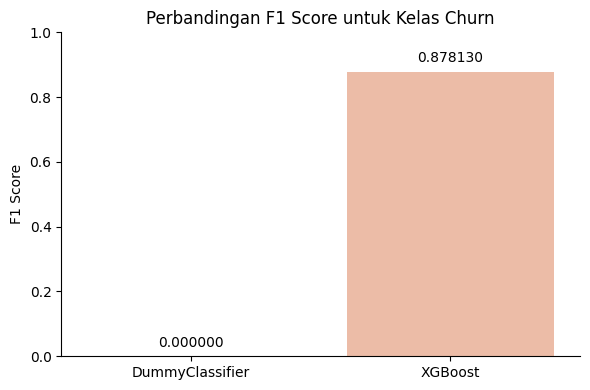

In [ ]:
# Data untuk visualisasi
model_names = ["DummyClassifier", "XGBoost"]
f1_scores = [f1_dummy, f1_xgb]

# Plot
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=model_names, y=f1_scores, hue=model_names, palette="coolwarm", legend=False)

# Tambahkan label angka presisi penuh di atas bar
for bar, score in zip(ax.patches, f1_scores):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02,
        f"{score:.6f}",  # tampilkan 6 digit desimal
        ha="center",
        va="bottom",
        fontsize=10
    )

# Styling
sns.despine()
plt.title("Perbandingan F1 Score untuk Kelas Churn")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

Terbukti model XGBoost jauh lebih efektif daripada Dummy yang tidak ada peranan sama sekali

Visualisasi di atas menunjukkan bahwa model XGBoost jauh lebih efektif dalam mendeteksi churn dibandingkan DummyClassifier, yang tidak memberikan kontribusi berarti. Perbedaan F1 Score yang signifikan membuktikan bahwa model yang dibangun mampu menghasilkan prediksi yang jauh lebih akurat daripada asumsi dasar tanpa model.


4. ANALISIS INTERPRETABILITAS MODEL

Logistic Regression dianalisis menggunakan koefisien model untuk memahami arah dan kekuatan pengaruh tiap fitur terhadap churn

XGBoost sebagai model non-interpretable, dianalisis menggunakan Permutation Feature Importance dan Partial Dependence Plot


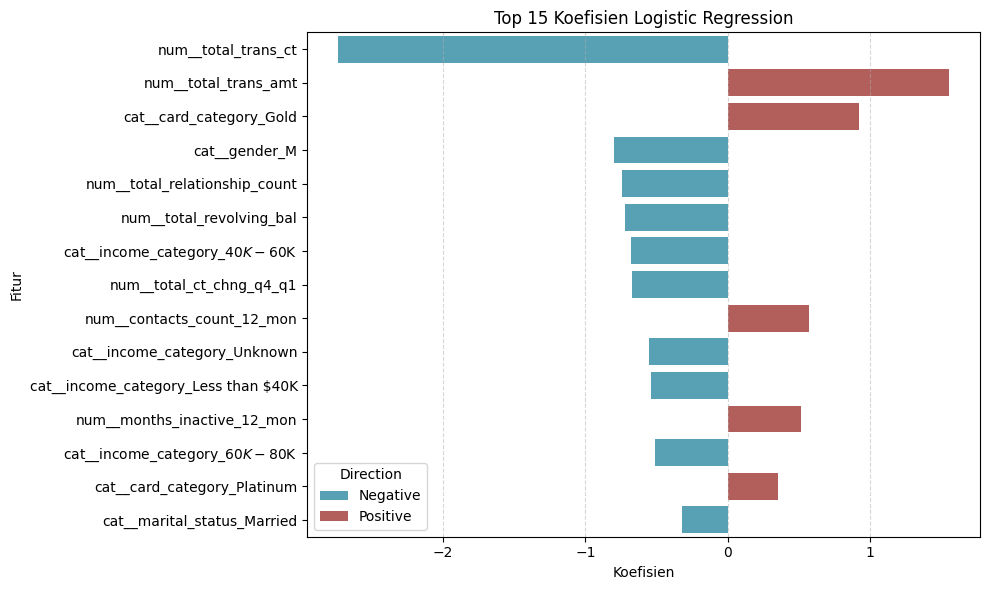

In [ ]:
# Ambil koefisien dan nama fitur
coef_lr = model_lr.coef_[0]
feature_names = preprocessor.get_feature_names_out()

# Buat DataFrame koefisien
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef_lr
})

# Tambahkan arah pengaruh
coef_df['Direction'] = coef_df['Coefficient'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

# Urutkan berdasarkan absolut nilai koefisien
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df_sorted = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Visualisasi
plt.figure(figsize=(10, 6))
sns.despine()
sns.barplot(data=coef_df_sorted.head(15), x='Coefficient', y='Feature', hue='Direction', dodge=False, palette={'Positive': HEX_RED, 'Negative': HEX_BLUE})
plt.title('Top 15 Koefisien Logistic Regression')
plt.xlabel('Koefisien')
plt.ylabel('Fitur')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Biru - negatif : Semakin tinggi nilai fitur, semakin kecil kemungkinan untuk churn

Merah - positif : Semakin tinggi nilai fitur, semakin besar kemungkinan untuk churn

Fitur num__total_trans_ct menjadi kontributor negatif paling dominan terhadap churn, ditandai dengan warna biru. Selisihnya cukup mencolok dibanding fitur-fitur negatif lain yang menyusul di bawahnya. Sebaliknya, num__total_trans_amt muncul sebagai kontributor positif paling dominan, diikuti oleh cat__card_category_Gold, keduanya ditandai dengan warna merah

XGBOOST (NON INTERPRETABLE)

Pendekatan yang digunakan adalah Permutation Feature Importance dan Partial Dependence Plot sesuai dengan ketentuan untuk model non-interpretable

Pendekatan ini memungkinkan identifikasi fitur-fitur yang paling berpengaruh terhadap churn serta pemahaman arah pengaruhnya secara visual

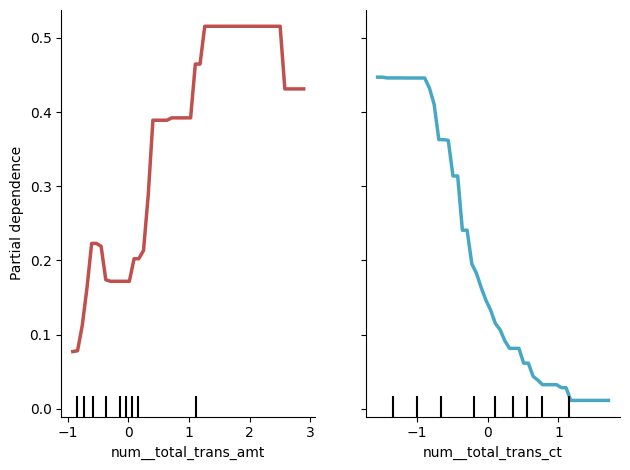

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

features_to_plot = ['num__total_trans_amt', 'num__total_trans_ct']
colors = ['#c0504d', '#48a8c4']  # Merah untuk positif, biru untuk negatif

display = PartialDependenceDisplay.from_estimator(
    model_xgb,
    X_train_df,
    features=features_to_plot,
    kind='average',
    feature_names=X_train_df.columns,
    grid_resolution=50
)

# Ubah warna dan ketebalan garis
for ax, color in zip(display.axes_.ravel(), colors):
    for line in ax.lines:
        line.set_color(color)
        line.set_linewidth(2.5)

sns.despine()
plt.tight_layout()
plt.show()

num__total_trans_amt menunjukkan semakin tinggi total transaksi (dalam rupiah), probabilitas churn menurun. Warna merah di sebagai zona aman — pelanggan aktif secara finansial bertahan

num__total_trans_ct menunjukkan jumlah transaksi yang rendah berkorelasi dengan peningkatan risiko churn. Warna biru sebagai zona bahaya — pelanggan jarang bertransaksi lebih mungkin churn

In [ ]:
# Analisis Korelasi atau Distribusi
df_clean.groupby('churn', observed=False)['months_on_book'].mean()

,months_on_book
churn,
1,36.178242
0,35.880588


Data menunjukkan bahwa nasabah yang churn, rata-rata memiliki masa bergabung sedikit lebih lama dibandingkan yang tidak churn, meskipun selisihnya kecil."

In [ ]:
# Cek rata-rata interaksi per churn status
df_clean.groupby('churn', observed=False)['contacts_count_12_mon'].mean()

,contacts_count_12_mon
churn,
1,2.972342
0,2.356353


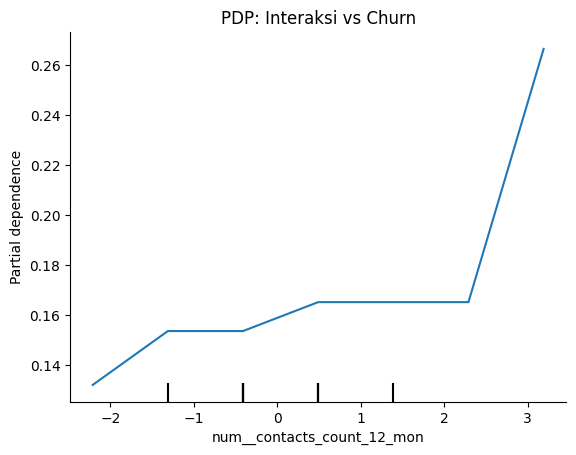

In [ ]:
# Interaksi vs Churn

from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    model_xgb,
    X_train_df,
    ['num__contacts_count_12_mon'],
    kind='average',
    grid_resolution=50
)
plt.title("PDP: Interaksi vs Churn")
sns.despine()
plt.show()

Semakin sering nasabah berinteraksi (melalui kontak yang tercatat dalam fitur ini), semakin tinggi kemungkinan rata-rata mereka untuk churn

Interaksi di sini terkait dengan masalah atau proses penutupan akun, bukan interaksi rutin yang positif, yang menjelaskan mengapa frekuensi tinggi berkorelasi dengan churn.

Interpretasi ini didasarkan langsung pada tren yang terlihat pada plot PDP yaitu garis yang meningkat dari kiri ke kanan

Kesimpulan dan Rekomendasi Bisnis

Berdasarkan hasil analisis dan pemodelan churn nasabah:

- Model XGBoost menunjukkan performa sangat tinggi (ROC AUC : 0.99, F1 Score : 0.88), menjadikannya kandidat utama untuk deployment.
- Fitur yang paling berpengaruh terhadap churn adalah:
  - **Total Transaksi (jumlah dan nilai)** : Semakin rendah, semakin tinggi risiko churn.
  - **Kategori Kartu** : Nasabah dengan kartu Gold cenderung lebih berisiko.
  - **Frekuensi Kontak dan Interaksi** : Nasabah yang jarang berinteraksi lebih rentan churn.

### Rekomendasi :
- Fokuskan intervensi pada nasabah dengan frekuensi transaksi rendah dan nilai transaksi kecil.
- Prioritaskan retensi untuk nasabah dengan kartu Gold dan interaksi rendah.
- Gunakan model XGBoost untuk scoring churn secara berkala dan integrasikan ke sistem CRM untuk tindakan preventif.

Laporan ini dapat digunakan oleh tim bisnis untuk memahami pola churn dan merancang strategi retensi yang lebih efektif